In [1]:
import os
import numpy as np
from torch import nn, load as LOAD_MODEL, tensor as TENSOR, float32 as float32, no_grad as no_grad, cat as cat, sigmoid as sigmoid, numel as numel
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.text import Text

device = 'cpu'
path = os.path.abspath('../..')
path

'/home/upadesh/3_Codes/6_Au_Au_Laser'

In [2]:
# UNet model definition
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, model_depth='low'):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        if model_depth == 'medium':
            # # Light Model
            self.encoder1 = conv_block(in_channels, 32)
            self.encoder2 = conv_block(32, 64)
            self.encoder3 = conv_block(64, 128)
            self.encoder4 = conv_block(128, 256)
            self.pool = nn.MaxPool2d(2)
            self.middle = conv_block(256, 512)
            self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
            self.decoder4 = conv_block(512, 256)
            self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.decoder3 = conv_block(256, 128)
            self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.decoder2 = conv_block(128, 64)
            self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
            self.decoder1 = conv_block(64, 32)
            self.final = nn.Conv2d(32, out_channels, kernel_size=1)
        
        elif model_depth == 'low':
            # # Ultra-light model
            self.encoder1 = conv_block(in_channels, 16)
            self.encoder2 = conv_block(16, 32)
            self.encoder3 = conv_block(32, 64)
            self.encoder4 = conv_block(64, 128)
            self.pool = nn.MaxPool2d(2)
            self.middle = conv_block(128, 256)
            self.upconv4 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
            self.decoder4 = conv_block(256, 128)
            self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
            self.decoder3 = conv_block(128, 64)
            self.upconv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
            self.decoder2 = conv_block(64, 32)
            self.upconv1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
            self.decoder1 = conv_block(32, 16)
            self.final = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        middle = self.middle(self.pool(enc4))

        dec4 = self.upconv4(middle)
        dec4 = self.pad_and_crop(enc4, dec4)
        dec4 = cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = self.pad_and_crop(enc3, dec3)
        dec3 = cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = self.pad_and_crop(enc2, dec2)
        dec2 = cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = self.pad_and_crop(enc1, dec1)
        dec1 = cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        out = self.final(dec1)
        return out

    def pad_and_crop(self, target, tensor):
        _, _, target_height, target_width = target.size()
        _, _, tensor_height, tensor_width = tensor.size()

        # Padding
        pad_h = max(0, target_height - tensor_height)
        pad_w = max(0, target_width - tensor_width)

        pad_left = pad_w // 2
        pad_right = pad_w - pad_left
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top

        tensor = nn.functional.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)

        # Cropping
        delta_h = (tensor.size(2) - target_height) // 2
        delta_w = (tensor.size(3) - target_width) // 2

        return tensor[:, :, delta_h: delta_h + target_height, delta_w: delta_w + target_width]

model_depth = 'medium' # deepest bottleneck (model_bns) block of low : 256, medium : 512
model_bns = '512'
model = UNet(in_channels=1, out_channels=1, model_depth=model_depth).to(device)
model.load_state_dict(LOAD_MODEL(path+f'/7_Virtual_Digital_Twin/model/FIT2TDB/{model_depth}/model_{model_bns}.pth'))

<All keys matched successfully>

In [57]:
t_step = 14
dt = 0.24*2
time = np.arange(0.96, 24.48, dt)
T_data = np.load(path+f'/7_Virtual_Digital_Twin/T_data/individual_T_data/Ring_X_{t_step}.npy')
T_data = TENSOR(T_data, dtype=float32)
LIQ_ML = ((sigmoid(model(T_data)) > 0.5).float().numpy())[0,0,:,:]
T_data = (T_data.numpy())[0,0,:,:]

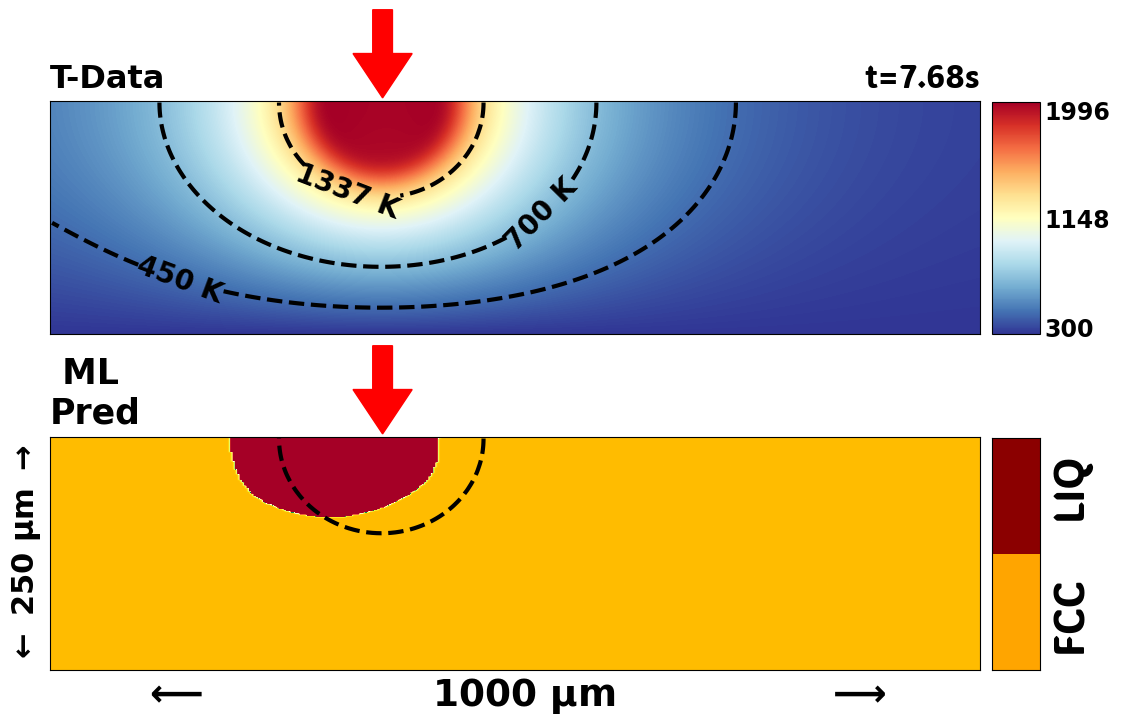

In [58]:
laser_speed = 30
laser_pos = (125 + time[t_step] * laser_speed) * 401 / 1000  # Laser actual position in true dimension

# Create the figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.set_title(f't={time[t_step]}s', pad=10, loc='right', fontsize=23, weight='bold', fontfamily='ADLaM Display')
# Plot T_data
cmap = plt.get_cmap('RdYlBu_r')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(T_data, cmap='RdYlBu_r', vmin=300, aspect=0.5,  interpolation='quadric')
ax1.set_title('T-Data', pad=10, loc='left', fontsize=23, weight='bold')
ax1.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax1.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_ylim(200, -1);  ax1.set_xlim(-1,400)
contour_levels = [450, 700, 1337]
label_colors = ['k', 'k', 'k']
contour = ax1.contour(T_data, levels=contour_levels, colors='black', linewidths=3, linestyles='dashed')
labels = plt.clabel(contour, inline=True, fontsize=20, fmt='%1.0f K')
for label, color in zip(labels, label_colors): label.set_fontweight('bold');label.set_color(color) 
############## Color Bar ##########
ax1a = fig.add_axes([0.91, 0.56, 0.04, 0.29]) 
cbar = fig.colorbar(hmap1, cax=ax1a)
cbar.ax.tick_params(labelsize=17,length=0)
cbar.set_ticks([np.min(T_data)*1.15, (np.max(T_data)+300)/2, np.max(T_data)*0.97], labels=[f'{np.min(T_data):.0f}', f'{(np.max(T_data)+300)/2 :.0f}', f'{np.max(T_data):.0f}'], weight='bold') 
line = Line2D([1.015, 1.015], [0.57, 0.82], transform=fig.transFigure, color="none", linewidth=3, linestyle='-')
fig.add_artist(line)

# Plot ML
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap4a = ax2.imshow(LIQ_ML, cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4b = ax2.imshow(1-LIQ_ML, cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax2.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax2.set_ylim(200, -1);  ax2.set_xlim(-1,400)
ax2.set_title(' ML\nPred', pad=10, loc='left', fontsize=25, weight='bold')
ax2.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax2.contour(T_data, levels=[1337], colors='black', linewidths=3, linestyles='dashed')
ax2.annotate(r'$\mathbf{\leftarrow}$ 250 $\mathbf{\mu m}$ $\mathbf{\rightarrow}$', xy=(0.5, 0.5), xytext=(-0.025, 0.5), rotation=90, xycoords='axes fraction', textcoords='axes fraction', fontsize = 22, weight = 'bold', color='k', ha='center', va='center')
ax2.set_xlabel('$\mathbf{\longleftarrow}$                 1000 $ \mathbf{\mu m}$                $\mathbf{\longrightarrow}$', fontsize = 27, weight ='bold',)

# ############## Color Bar ##########
ax4a = fig.add_axes([0.91, 0.14, 0.04, 0.29]) 
cmap = ListedColormap(['#8B0000', '#FFA500'])
data = np.array([[0], [1]])
cbar = ax4a.imshow(data, cmap=cmap, aspect='auto')
ax4a.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
text = Text(x=0.96, y=0.17, text=r'FCC     LIQ', fontsize=30, color='k', rotation=90, weight='bold', fontfamily='ADLaM Display')
fig.add_artist(text)
plt.show()

## With Prediction Error

In [5]:
LIQ_PF = np.load(path+f'/7_Virtual_Digital_Twin/T_data/individual_y_data/Ring_y_{t_step}.npy')[0,0,:,:]

In [6]:
pred_error_PFT = LIQ_ML - LIQ_PF

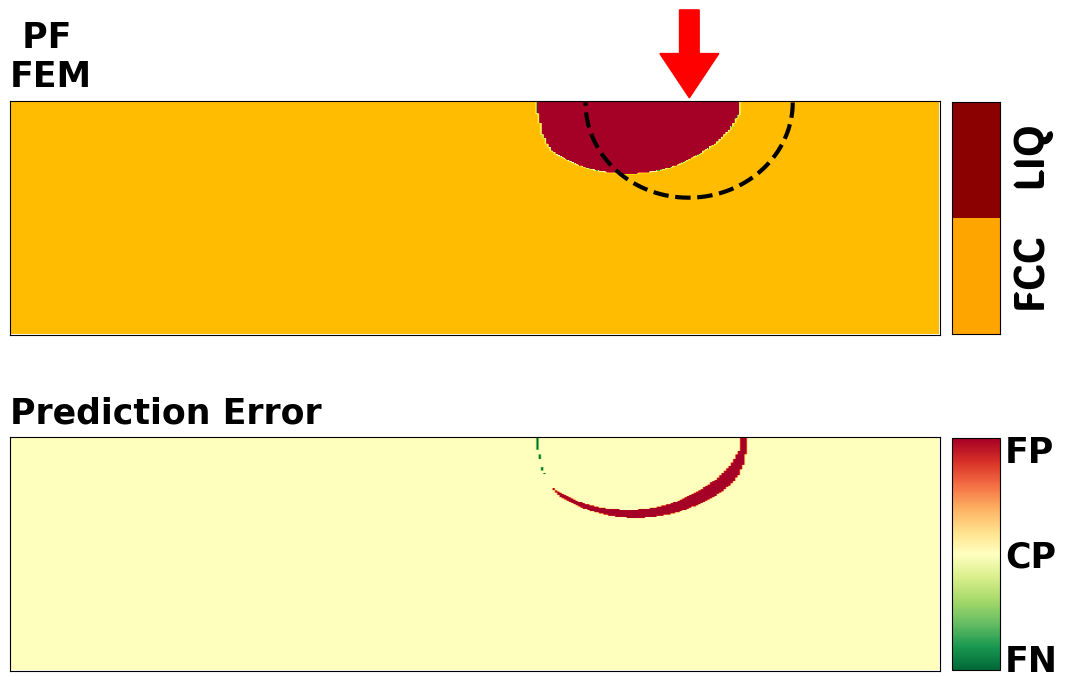

In [33]:

fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 8))

cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap2 = ax3.imshow(LIQ_PF, cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5)
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap2 = ax3.imshow(1-LIQ_PF, cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax3.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax3.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax3.set_ylim(201, -1);  ax3.set_xlim(-1,401)
ax3.set_title(' PF\nFEM', pad=10, loc='left', fontsize=25, weight='bold')
ax3.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax3.contour(T_data, levels=[1337], colors='black', linewidths=3, linestyles='dashed')
# ############## Color Bar ##########
ax6a = fig2.add_axes([0.91, 0.56, 0.04, 0.29]) 
cmap = ListedColormap(['#8B0000', '#FFA500'])
data = np.array([[0], [1]])
cbar = ax6a.imshow(data, cmap=cmap, aspect='auto')
ax6a.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
text = Text(x=0.96, y=0.6, text=r'FCC    LIQ', fontsize=30, color='k', rotation=90, weight='bold', fontfamily='ADLaM Display')
fig2.add_artist(text)


cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax4.imshow(pred_error_PFT, cmap=cmap, vmin=-1, vmax=1, aspect=0.5)
ax4.set_title('Prediction Error', pad=10, loc='left', fontsize=25, weight='bold')
ax4.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax4.arrow(laser_pos, -80, 0, 76,  width = 8.5, color='none', length_includes_head=True, clip_on=False)
ax4.set_ylim(201, -1);  ax4.set_xlim(-1,401)
ax7a = fig2.add_axes([0.91, 0.14, 0.04, 0.29]) 
cbar = fig2.colorbar(hmap3, cax=ax7a, orientation='vertical')
cbar.ax.tick_params(labelsize=25, length=0,)# direction='inout', length=20, width=5, rotation=0) 
cbar.set_ticks([-0.90,0,0.90], labels=['FN','CP','FP'], weight='bold')


plt.show()